# 02 Prepare Health Outcomes

**Project:** NORI  
**Author:** Yuseof J  
**Date:** 10/12/25  

### **Purpose**
Load the raw CDC PLACES data, filter for NYC tracts and select the health metrics that will be used in modeling.

### **Inputs**
- `data/raw/cdc_places.csv`
- `data/processed/nyc_tracts.gpkg`

### **Outputs**
- `data/processed/outcomes_health.csv`
- `data/processed/nyc_tracts.gpkg (layer = health_outcomes)`
--------------------------------------------------------------------------

### 0. Imports and Setup

In [136]:
# package imports
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

# specify filepaths
path_cdc_places = 'data/raw/cdc_places.csv'
path_nyc_tracts = 'data/processed/nyc_tracts.gpkg'
path_output_health_outcomes = 'data/processed/outcomes_health.csv'
output_gpkg_layer = 'health_outcomes'

# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

### 1. Load Data

In [137]:
# cdc places
df_cdc = pd.read_csv(path_cdc_places)

# nyc tracts
gdf_tracts_nyc = gpd.read_file(path_nyc_tracts, layer="tracts")

### 2. EDA 

In [138]:
df_cdc.columns.tolist()

['StateAbbr',
 'StateDesc',
 'CountyName',
 'CountyFIPS',
 'TractFIPS',
 'TotalPopulation',
 'TotalPop18plus',
 'ACCESS2_CrudePrev',
 'ACCESS2_Crude95CI',
 'ARTHRITIS_CrudePrev',
 'ARTHRITIS_Crude95CI',
 'BINGE_CrudePrev',
 'BINGE_Crude95CI',
 'BPHIGH_CrudePrev',
 'BPHIGH_Crude95CI',
 'BPMED_CrudePrev',
 'BPMED_Crude95CI',
 'CANCER_CrudePrev',
 'CANCER_Crude95CI',
 'CASTHMA_CrudePrev',
 'CASTHMA_Crude95CI',
 'CHD_CrudePrev',
 'CHD_Crude95CI',
 'CHECKUP_CrudePrev',
 'CHECKUP_Crude95CI',
 'CHOLSCREEN_CrudePrev',
 'CHOLSCREEN_Crude95CI',
 'COLON_SCREEN_CrudePrev',
 'COLON_SCREEN_Crude95CI',
 'COPD_CrudePrev',
 'COPD_Crude95CI',
 'CSMOKING_CrudePrev',
 'CSMOKING_Crude95CI',
 'DENTAL_CrudePrev',
 'DENTAL_Crude95CI',
 'DEPRESSION_CrudePrev',
 'DEPRESSION_Crude95CI',
 'DIABETES_CrudePrev',
 'DIABETES_Crude95CI',
 'GHLTH_CrudePrev',
 'GHLTH_Crude95CI',
 'HIGHCHOL_CrudePrev',
 'HIGHCHOL_Crude95CI',
 'LPA_CrudePrev',
 'LPA_Crude95CI',
 'MAMMOUSE_CrudePrev',
 'MAMMOUSE_Crude95CI',
 'MHLTH_CrudePr

**Health Outcomes of Interest**

- **CASTHMA_CrudePrev** : asthma prevalence
- **DIABETES_CrudePrev** : diabetes prevalance
- **MHLTH_CrudePrev** : poor mental health days
- **OBESITY_CrudePrev** : obesity prevalance

In [139]:
# select columns of interest
df_health_outcomes = df_cdc[['TractFIPS',
                             'CASTHMA_CrudePrev',
                             'DIABETES_CrudePrev',
                             'MHLTH_CrudePrev',
                             'OBESITY_CrudePrev']].copy()

In [140]:
df_health_outcomes.head()

,TractFIPS,CASTHMA_CrudePrev,DIABETES_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev
0,1001020100,10.2,13.3,17.9,39.4
1,1001020200,10.8,15.8,18.5,44.7
2,1001020300,10.7,13.9,18.6,40.3
3,1001020400,9.6,12.8,15.8,36.9
4,1001020501,9.3,10.2,14.8,34.7


Ditribution of Health Outcomes - Nationwide

array([[<Axes: title={'center': 'CASTHMA_CrudePrev'}>,
        <Axes: title={'center': 'DIABETES_CrudePrev'}>],
       [<Axes: title={'center': 'MHLTH_CrudePrev'}>,
        <Axes: title={'center': 'OBESITY_CrudePrev'}>]], dtype=object)

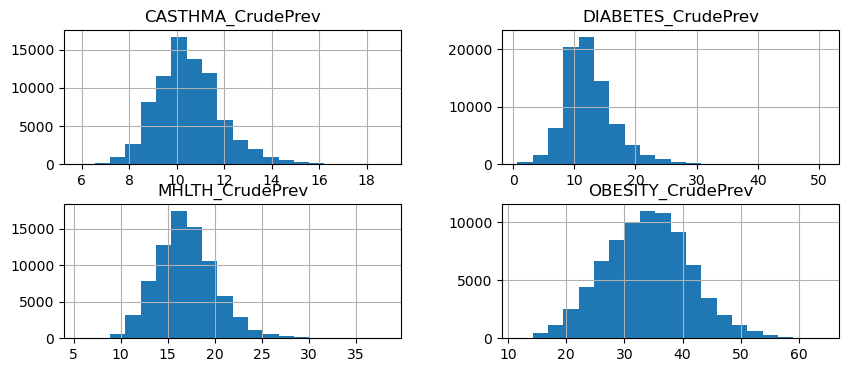

In [141]:
df_health_outcomes[['CASTHMA_CrudePrev','DIABETES_CrudePrev','MHLTH_CrudePrev', 'OBESITY_CrudePrev']].hist(bins=20, figsize=(10,4))

Percent of tracts without health outcome meaurements

In [142]:
df_health_outcomes.isna().sum() / df_health_outcomes.TractFIPS.nunique() * 100

TractFIPS             0.000000
CASTHMA_CrudePrev     5.635641
DIABETES_CrudePrev    5.635641
MHLTH_CrudePrev       5.635641
OBESITY_CrudePrev     5.635641
dtype: float64

### 3. Data Processing and Filtering

Throughout the project, percent values are left in decimal form (i.e. 25% is 0.25). Here we will reformat the CDC Places data to take on the same format, sinse they are currently in '25' format.

In [149]:
outcome_cols = df_health_outcomes.columns.tolist() 
outcome_cols.remove('TractFIPS')

for col in outcome_cols:
    if (df_health_outcomes[col] > 1).any():
        df_health_outcomes[col] = df_health_outcomes[col] / 100   

Filter health outcomes for only NYC tracts

In [150]:
# ensure matching dtypes for join
gdf_tracts_nyc.GEOID = gdf_tracts_nyc.GEOID.astype(int)
df_health_outcomes.TractFIPS = df_health_outcomes.TractFIPS.astype(int)

# join on tract ID to get health outcomes for NYC tracts
gdf_tracts_nyc_health_outcomes = gdf_tracts_nyc.merge(df_health_outcomes,
                                                         how='left',
                                                         left_on='GEOID',
                                                         right_on='TractFIPS')
gdf_tracts_nyc_health_outcomes.drop(columns=['TractFIPS'], inplace=True) # duplicate col, already have GEOID

# create a seperate health outcome csv for modeling
df_health_outcomes_nyc = gdf_tracts_nyc_health_outcomes[['GEOID',
                                                         'CASTHMA_CrudePrev',
                                                         'DIABETES_CrudePrev',
                                                         'MHLTH_CrudePrev',
                                                         'OBESITY_CrudePrev']].copy()

In [151]:
# inspect tract coverage (%)
gdf_tracts_nyc_health_outcomes[['CASTHMA_CrudePrev',
                                'DIABETES_CrudePrev',
                                'MHLTH_CrudePrev', 
                                'OBESITY_CrudePrev']].notna().sum() /  gdf_tracts_nyc_health_outcomes.GEOID.nunique() * 100

CASTHMA_CrudePrev     95.874517
DIABETES_CrudePrev    95.874517
MHLTH_CrudePrev       95.874517
OBESITY_CrudePrev     95.874517
dtype: float64

About 96% coverage for NYC tracts!

Ditribution of Health Outcomes - NYC

array([[<Axes: title={'center': 'CASTHMA_CrudePrev'}>,
        <Axes: title={'center': 'DIABETES_CrudePrev'}>],
       [<Axes: title={'center': 'MHLTH_CrudePrev'}>,
        <Axes: title={'center': 'OBESITY_CrudePrev'}>]], dtype=object)

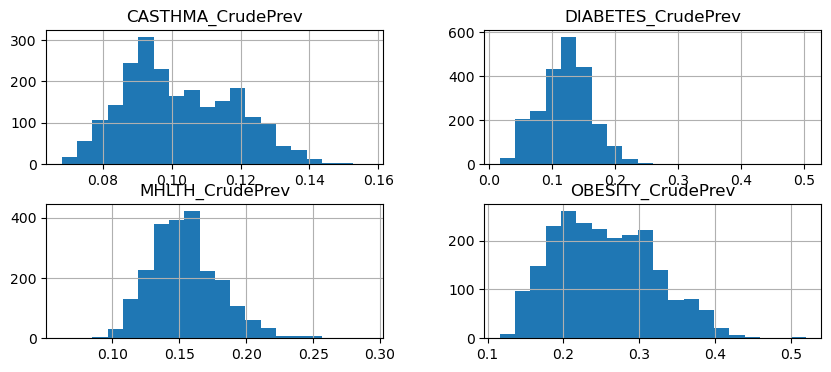

In [152]:
df_health_outcomes_nyc[['CASTHMA_CrudePrev','DIABETES_CrudePrev','MHLTH_CrudePrev', 'OBESITY_CrudePrev']].hist(bins=20, figsize=(10,4))

### 4. Save Data

In [153]:
# save health outcomes to nyc tracts gpkg as new layer 
gdf_tracts_nyc_health_outcomes.to_file(path_nyc_tracts, layer=output_gpkg_layer)

# save health outcomes for modeling
df_health_outcomes_nyc.to_csv(path_output_health_outcomes, index=False)